In [59]:
import numpy as np
# import torch 
# !pip3 install lightgbm
# !pip3 install xgboost
# !pip3 install catboost
# !pip3 install tqdmt
# from sklearn.metrics import accuracy_score,precision_score,f1_score
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt
import os
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
import gc
import wandb
import time
from wandb.lightgbm import wandb_callback
from sklearn.metrics import roc_auc_score
from collections import defaultdict
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

In [60]:
config = {
    'dataset': 'A',  # for Dataset A or Dataset B
    'sample_size': 100000,
    'dst_offset': 0,
}

if config['dataset'] == 'A':
    config['dst_offset'] = 0
else:
    config['dst_offset'] = 791332

In [61]:
if config['dataset'] == 'A':
    edge_data = pd.read_csv(f'../train_csvs/edges_train_A.csv', header=None, names=['src_id', 'dst_id', 'edge_type', 'timestamp'])
else:
    edge_data = pd.read_csv(f'../train_csvs/edges_train_B.csv', header=None, names=['src_id', 'dst_id', 'edge_type', 'timestamp', 'edge_feat'])

edge_data['dst_id'] += config['dst_offset']
    
# 利用训练数据，构图，并整合每一个三元组对下的 timestamp 列表
graph_for_exist = dict()

for idx, i in enumerate(tqdm(edge_data.values)):
    src_id = i[0]
    dst_id = i[1]
    edge_type = i[2]
    timestamp = i[3]
    
    if src_id not in graph_for_exist.keys():
        graph_for_exist[src_id] = dict()
    if dst_id not in graph_for_exist.keys():
        graph_for_exist[dst_id] = dict()
    if edge_type not in graph_for_exist[src_id].keys():
        graph_for_exist[src_id][edge_type] = dict()
    if edge_type not in graph_for_exist[dst_id].keys():
        graph_for_exist[dst_id][edge_type] = dict()
    if src_id not in graph_for_exist[dst_id][edge_type].keys():
        graph_for_exist[dst_id][edge_type][src_id] = []
    if dst_id not in graph_for_exist[src_id][edge_type].keys():
        graph_for_exist[src_id][edge_type][dst_id] = []
    
    graph_for_exist[src_id][edge_type][dst_id].append(timestamp)
    graph_for_exist[dst_id][edge_type][src_id].append(timestamp)

print('timestamp state done!')

for key in graph_for_exist.keys():
    for k2 in graph_for_exist[key].keys():
        for k3, value in graph_for_exist[key][k2].items():
            graph_for_exist[key][k2][k3] = sorted(value)

print('done!')

100%|██████████| 27045268/27045268 [03:02<00:00, 148506.62it/s]


timestamp state done!
done!


In [62]:
# 方案三采样方法构造训练集
edge_csv = edge_data.sample(config['sample_size']).drop(columns=['timestamp', 'edge_feat'], errors='ignore')
edge_csv['start_time'] = edge_csv['end_time'] = 0
edge_csv['label'] = 1

# 方案三：根据原始边缘信息，重新采样，以下开始负样本采样
src_id_col = edge_csv['src_id'].values.copy()
dst_id_col = edge_csv['dst_id'].values.copy()
edge_type_col = edge_csv['edge_type'].values.copy()
np.random.shuffle(dst_id_col)  # dst id 与 edge type 列重新生成
np.random.shuffle(edge_type_col)
negative_edge_csv = pd.DataFrame(
    {'src_id': src_id_col,
     'dst_id': dst_id_col,
     'edge_type': edge_type_col,
     'start_time': 0,
     'end_time': 0,
     'label': 0})
train_a_data = pd.concat([edge_csv, negative_edge_csv]).reset_index(drop=True)
train_a_data = pd.DataFrame(np.concatenate([train_a_data.values, train_a_data.values[:, [1, 0, 2, 3, 4, 5]], ]),
                            # 双向边
                            columns=['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time', 'label'])
train_a_data

,src_id,dst_id,edge_type,start_time,end_time,label
0,31663,62299,71,0,0,1
1,26464,45285,147,0,0,1
2,36463,49022,151,0,0,1
3,21066,28905,20,0,0,1
4,39224,57474,65,0,0,1
...,...,...,...,...,...,...
399995,28905,22840,244,0,0,0
399996,28905,62568,20,0,0,0
399997,45285,41707,74,0,0,0
399998,18933,45285,93,0,0,0


In [63]:
if config['dataset'] == 'A':
    # train_a_data = pd.read_csv('../train_csvs/new_train_A_100000.csv')
    train_a_node_features = pd.read_csv('../train_csvs/node_features.csv', header=None, names=['node_id', "feat_0", 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7'])
    train_a_edge_type_features = pd.read_csv('../train_csvs/edge_type_features.csv', header=None, names=['edge_type_id', "feat_0", 'feat_1', 'feat_2',])

dev_a_data = pd.read_csv(f'../test_csvs/input_{config["dataset"]}_initial.csv', header=None, names=['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time', 'label'])
mid_a_data = pd.read_csv(f'../test_csvs/input_{config["dataset"]}.csv', header=None, names=['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time'])
test_a_data = pd.read_csv(f'../test_csvs/input_{config["dataset"]}_final.csv', header=None, names=['src_id', 'dst_id', 'edge_type', 'start_time', 'end_time'])
test_a_data['label'] = mid_a_data['label'] = -1

In [64]:
train_a_data['test_flag'] = 0
dev_a_data['test_flag'] = 1
mid_a_data['test_flag'] = 2
test_a_data['test_flag'] = 3

tmp_test_data = pd.concat([dev_a_data, mid_a_data, test_a_data])
tmp_test_data['dst_id'] += config['dst_offset']

all_data = pd.concat([train_a_data, tmp_test_data], ignore_index=True)

if config['dataset'] == 'A':
    all_data = all_data.merge(train_a_node_features, how='left', left_on='src_id', right_on='node_id')
    all_data.drop(columns=['node_id'], axis=0, inplace=True)
    all_data = all_data.merge(train_a_node_features, how='left', left_on='dst_id', right_on='node_id')
    all_data.drop(columns=['node_id'], axis=0, inplace=True)
    all_data = all_data.merge(train_a_edge_type_features, how='left', left_on='edge_type', right_on='edge_type_id')
    all_data.drop(columns=['edge_type_id'], axis=0, inplace=True)

all_data# .head(10)

,src_id,dst_id,edge_type,start_time,end_time,label,test_flag,feat_0_x,feat_1_x,feat_2_x,...,feat_1_y,feat_2_y,feat_3_y,feat_4_y,feat_5_y,feat_6_y,feat_7_y,feat_0,feat_1,feat_2
0,31663,62299,71,0,0,1,0,-1,-1,-1,...,-1,-1,-1,-1,155,-1,-1,216,13,134
1,26464,45285,147,0,0,1,0,14,-1,-1,...,-1,-1,-1,-1,155,-1,-1,122,10,135
2,36463,49022,151,0,0,1,0,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,109,13,116
3,21066,28905,20,0,0,1,0,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,218,15,8
4,39224,57474,65,0,0,1,0,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,86,10,119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658095,69980,49214,176,1494875670,1494996140,-1,3,29,-1,-1,...,-1,-1,-1,32,171,-1,-1,159,18,110
658096,69980,52874,33,1498584288,1498694102,-1,3,29,-1,-1,...,-1,-1,-1,-1,155,-1,8,148,13,45
658097,69980,55746,209,1497952740,1498081488,-1,3,29,-1,-1,...,-1,-1,-1,16,-1,-1,-1,209,9,0
658098,69980,60642,71,1497166072,1497356374,-1,3,29,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,216,13,134


In [65]:
from collections import defaultdict

# 一元信息构造
node_adj_info = dict()

# 二元信息构造
two_node_adj_info = dict()

# 三元信息构造
si = edge_data['dst_id']
di = edge_data['src_id']

edge_data_tmp = edge_data.copy()
edge_data_tmp['src_id'] = si
edge_data_tmp['dst_id'] = di
edge_data_bi = pd.concat([edge_data, edge_data_tmp])
triple_node_adj_info = edge_data_bi.groupby(['src_id', 'dst_id', 'edge_type']).count().reset_index().rename(columns={'timestamp': 'sparse:group_val_(src_id,dst_id,edge_type)_count'})
del edge_data_tmp, edge_data_bi

for idx, (node_id, value) in enumerate(tqdm(graph_for_exist.items())):
    du = 0 # 节点的度，一共有多少条边
    unique_adj_node = set()
    nunique_adj_edge = len(value) # 节点一共邻接多少个不同边
    
    to_edge_dict = defaultdict(dict)  # key: dst_id, value: {edge_type: num, edge_type2: num2}
    
    for edge_type, adj_nodes in value.items():
        # print(edge_type, adj_nodes)
        for dst_id, tss in adj_nodes.items():
            unique_adj_node.add(dst_id)
            du += len(tss)
            
            to_edge_dict[dst_id][edge_type] = len(tss)
        
    node_adj_info[node_id] = {
        'sparse:group_val_(src_id)_count': du,
        'sparse:group_val_(src_id)_dst_id_nunique': len(unique_adj_node), # 节点一共邻接多少个不同点
        'sparse:group_val_(src_id)_edge_type_nunique': nunique_adj_edge,
    }
    for dst_id, info in to_edge_dict.items():
        two_node_adj_info[(node_id, dst_id)] = {
            'sparse:group_val_(src_id,dst_id)_count': sum(info.values()),
            'sparse:group_val_(src_id,dst_id)_edge_type_nunique': len(info),
        }

100%|██████████| 19442/19442 [00:40<00:00, 476.98it/s] 


In [66]:
node_adj_info_pd = pd.DataFrame.from_dict(node_adj_info, orient='index').reset_index()
two_node_adj_info_pd = pd.DataFrame.from_dict(two_node_adj_info, orient='index').reset_index()

two_node_adj_info_pd

,level_0,level_1,"sparse:group_val_(src_id,dst_id)_count","sparse:group_val_(src_id,dst_id)_edge_type_nunique"
0,106,28905,91306,188
1,106,39520,6671,121
2,106,45915,6505,129
3,106,61213,3013,109
4,106,27194,186,37
...,...,...,...,...
2925753,20584,50050,4,3
2925754,20584,64560,2,2
2925755,20584,45915,1,1
2925756,20584,28905,1,1


In [67]:
from scipy import sparse

row = []
col = []
data = []

for (src_id, dst_id), value in two_node_adj_info.items():
    row.append(src_id)
    col.append(dst_id)
    data.append(value['sparse:group_val_(src_id,dst_id)_count'])
one_hop_count_matrix = sparse.csr_matrix((data, (row, col)))
one_hop_count_matrix

<69984x69984 sparse matrix of type '<class 'numpy.int64'>'
	with 2925758 stored elements in Compressed Sparse Row format>

In [68]:
two_hop_count_matrix = one_hop_count_matrix * one_hop_count_matrix
two_hop_count_matrix

<69984x69984 sparse matrix of type '<class 'numpy.int64'>'
	with 374466676 stored elements in Compressed Sparse Row format>

In [69]:
two_hop_count_list = []

for i in tqdm(two_node_adj_info_pd.values):
    src_id = i[0]
    dst_id = i[1]
    two_hop_count_list.append(two_hop_count_matrix[src_id, dst_id])
    
two_node_adj_info_pd['two_hop_count_list'] = two_hop_count_list
two_node_adj_info_pd

100%|██████████| 2925758/2925758 [03:10<00:00, 15371.47it/s]


,level_0,level_1,"sparse:group_val_(src_id,dst_id)_count","sparse:group_val_(src_id,dst_id)_edge_type_nunique",two_hop_count_list
0,106,28905,91306,188,30637224999
1,106,39520,6671,121,15381684086
2,106,45915,6505,129,16506712019
3,106,61213,3013,109,4293185422
4,106,27194,186,37,517666723
...,...,...,...,...,...
2925753,20584,50050,4,3,1815
2925754,20584,64560,2,2,213462
2925755,20584,45915,1,1,177922
2925756,20584,28905,1,1,597560


In [70]:
# 拼接一元信息
all_data = all_data.merge(node_adj_info_pd, how='left', left_on='src_id', right_on='index').drop(columns=['index'], axis=0)
# 拼接二元信息
all_data = all_data.merge(node_adj_info_pd, how='left', left_on='dst_id', right_on='index').drop(columns=['index'], axis=0)
# 拼接三元信息
all_data = all_data.merge(two_node_adj_info_pd, how='left', left_on=['src_id', 'dst_id'], right_on=['level_0', 'level_1']).fillna(0).drop(columns=['level_0', 'level_1'], axis=0)
all_data = all_data.merge(triple_node_adj_info, how='left', left_on=['src_id', 'dst_id', 'edge_type'], right_on=['src_id', 'dst_id', 'edge_type']).fillna(0)

In [71]:
all_data

,src_id,dst_id,edge_type,start_time,end_time,label,test_flag,feat_0_x,feat_1_x,feat_2_x,...,sparse:group_val_(src_id)_count_x,sparse:group_val_(src_id)_dst_id_nunique_x,sparse:group_val_(src_id)_edge_type_nunique_x,sparse:group_val_(src_id)_count_y,sparse:group_val_(src_id)_dst_id_nunique_y,sparse:group_val_(src_id)_edge_type_nunique_y,"sparse:group_val_(src_id,dst_id)_count","sparse:group_val_(src_id,dst_id)_edge_type_nunique",two_hop_count_list,"sparse:group_val_(src_id,dst_id,edge_type)_count"
0,31663,62299,71,0,0,1,0,-1,-1,-1,...,21153,1256,175,213020,3704,221,36.0,13.0,1.299685e+08,1.0
1,26464,45285,147,0,0,1,0,14,-1,-1,...,525550,7081,219,3295131,11958,245,77684.0,184.0,1.058126e+11,358.0
2,36463,49022,151,0,0,1,0,-1,-1,-1,...,298543,3574,217,114832,3726,196,315.0,49.0,2.353738e+09,36.0
3,21066,28905,20,0,0,1,0,-1,-1,-1,...,65440,2697,198,9675998,19179,246,13033.0,163.0,2.213092e+09,652.0
4,39224,57474,65,0,0,1,0,-1,-1,-1,...,11358,1265,170,45401,2642,169,18.0,5.0,2.538742e+07,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658095,69980,49214,176,1494875670,1494996140,-1,3,29,-1,-1,...,3746,607,148,44551,1569,189,30.0,15.0,3.652753e+06,0.0
658096,69980,52874,33,1498584288,1498694102,-1,3,29,-1,-1,...,3746,607,148,4372,491,130,0.0,0.0,0.000000e+00,0.0
658097,69980,55746,209,1497952740,1498081488,-1,3,29,-1,-1,...,3746,607,148,777,183,78,0.0,0.0,0.000000e+00,0.0
658098,69980,60642,71,1497166072,1497356374,-1,3,29,-1,-1,...,3746,607,148,728553,10035,234,93.0,24.0,5.185534e+07,10.0


## 拼接外部 node embedding

In [72]:
def read_emb_data(filepath):
    if not os.path.exists(filepath):
        return dict()
    f = open(filepath, 'r')
    num_count, num_dim = map(int, f.readline().split())

    node_id_emb = dict()
    for data in f.readlines():
        data = data.strip().split(' ')

        node_id = int(data[0])
        embed = np.array(data[1:], dtype=float)
        node_id_emb[node_id] = embed
    return node_id_emb

# 使用 LINE 生成的 embedding
emb_path = f'../embs/dataset_{config["dataset"]}_graph_src_dst_id.emb'
all_node_emb = read_emb_data(emb_path)
all_node_emb_pd = pd.DataFrame.from_dict(all_node_emb, orient='index')

In [73]:
all_data = all_data.merge(all_node_emb_pd, how='left', left_on='src_id', right_index=True)
all_data = all_data.merge(all_node_emb_pd, how='left', left_on='dst_id', right_index=True)
all_data

,src_id,dst_id,edge_type,start_time,end_time,label,test_flag,feat_0_x,feat_1_x,feat_2_x,...,190_y,191_y,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y
0,31663,62299,71,0,0,1,0,-1,-1,-1,...,-0.307947,-0.231288,-0.036013,-0.062214,0.135924,-0.120684,-0.114572,0.020445,0.077689,-0.008791
1,26464,45285,147,0,0,1,0,14,-1,-1,...,0.029757,-0.131960,-0.008382,-0.108266,0.040760,0.201408,-0.211159,0.042460,-0.163271,-0.132325
2,36463,49022,151,0,0,1,0,-1,-1,-1,...,-0.269917,0.107135,0.055891,0.067172,-0.202249,0.200384,-0.280685,0.064039,-0.378790,-0.497700
3,21066,28905,20,0,0,1,0,-1,-1,-1,...,0.100477,-0.038076,-0.001188,-0.139141,-0.131943,0.145833,-0.113107,0.038496,-0.032590,-0.072110
4,39224,57474,65,0,0,1,0,-1,-1,-1,...,0.117139,-0.087244,-0.421603,-0.112137,-0.219417,0.192235,-0.143928,-0.167680,0.148916,0.096696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658095,69980,49214,176,1494875670,1494996140,-1,3,29,-1,-1,...,0.371442,-0.105631,-0.183275,-0.214641,-0.051064,0.039020,0.047359,-0.026662,-0.223549,-0.363136
658096,69980,52874,33,1498584288,1498694102,-1,3,29,-1,-1,...,0.046679,-0.037193,-0.143745,0.035014,0.167295,-0.271332,-0.194710,-0.131918,0.402429,0.197424
658097,69980,55746,209,1497952740,1498081488,-1,3,29,-1,-1,...,-0.243592,-0.105645,0.012041,0.592462,0.084736,-0.049366,0.448350,0.221510,0.121660,0.118368
658098,69980,60642,71,1497166072,1497356374,-1,3,29,-1,-1,...,0.115532,0.109335,-0.061813,-0.052652,-0.005844,0.242444,-0.230357,-0.069731,-0.085827,-0.094216


In [74]:
all_node_emb_pd

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
106,-0.143679,-0.138066,-0.179022,-0.102941,-0.207637,0.174723,-0.137081,-0.154120,-0.086287,0.073061,...,0.117980,0.010178,-0.065338,-0.222921,-0.029158,-0.314173,0.226679,-0.052983,0.075873,0.028314
28905,-0.001197,0.030057,0.053251,0.043523,0.092522,0.016269,0.025599,0.007239,0.007997,-0.006152,...,0.100477,-0.038076,-0.001188,-0.139141,-0.131943,0.145833,-0.113107,0.038496,-0.032590,-0.072110
211,0.209864,0.330594,-0.482570,-0.420206,-0.084706,-0.109880,0.400507,-0.143710,-0.098350,-0.072692,...,0.021754,-0.141119,0.174974,-0.216684,0.160032,0.201967,-0.025257,0.001877,-0.259129,0.127460
14601,0.113454,0.086059,-0.046937,-0.060475,0.088795,0.390119,0.302458,-0.154821,0.270005,0.138436,...,-0.327196,-0.031784,0.199060,-0.099823,-0.004415,0.300817,-0.160443,0.176800,-0.052096,-0.219006
1355,-0.084775,0.217363,-0.012106,-0.178188,-0.021969,0.109538,-0.129507,0.220068,-0.299456,-0.188770,...,-0.110394,-0.082987,0.142234,0.054355,0.123355,-0.138678,-0.123969,-0.347867,0.127350,0.231687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19231,-0.435221,-0.297029,0.211241,-0.258996,-0.036141,0.055140,-0.038309,-0.033338,-0.016819,-0.052549,...,-0.068154,-0.172159,-0.057960,0.063320,0.266082,-0.049363,0.314149,-0.084570,0.230775,0.148773
66826,-0.010120,-0.176895,0.134907,-0.038027,0.167903,-0.021254,0.001469,0.064794,0.042762,0.059468,...,-0.142681,0.056983,0.032093,0.151746,0.031260,-0.074544,0.242160,0.112499,-0.124925,0.082595
59569,0.070693,-0.204979,0.032006,0.196028,0.246700,-0.080886,-0.114509,-0.226817,-0.165790,0.038977,...,-0.394152,0.118517,-0.269513,0.374551,0.107566,-0.205706,0.140370,0.120040,0.083487,0.037723
20584,0.055973,0.109655,-0.174843,-0.192254,-0.224077,0.020723,-0.375352,-0.122944,0.069258,0.112392,...,-0.120199,-0.093420,-0.026998,0.367186,0.243420,-0.060124,0.322676,0.157109,0.030997,0.160439


In [75]:
# 将 src_id, dst_id 两个节点 embedding 的点积以及余弦相似度加入特征中
def cos_sim(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    :param vector_a: 向量 a
    :param vector_b: 向量 b
    :return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

dot_product_list = []
cos_sim_list = []

for i in tqdm(all_data.values):
    src_id = int(i[0])
    dst_id = int(i[1])
    src_emb = all_node_emb[src_id]
    dst_emb = all_node_emb[dst_id]
    
    dot_product_list.append(sum(src_emb * dst_emb))
    cos_sim_list.append(cos_sim(src_emb, dst_emb))
    
all_data['dot_product'] = dot_product_list
all_data['cos_sim'] = cos_sim_list
all_data

100%|██████████| 658100/658100 [01:07<00:00, 9726.77it/s] 


,src_id,dst_id,edge_type,start_time,end_time,label,test_flag,feat_0_x,feat_1_x,feat_2_x,...,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y,dot_product,cos_sim
0,31663,62299,71,0,0,1,0,-1,-1,-1,...,-0.036013,-0.062214,0.135924,-0.120684,-0.114572,0.020445,0.077689,-0.008791,0.006271,0.500404
1,26464,45285,147,0,0,1,0,14,-1,-1,...,-0.008382,-0.108266,0.040760,0.201408,-0.211159,0.042460,-0.163271,-0.132325,2.004063,0.733322
2,36463,49022,151,0,0,1,0,-1,-1,-1,...,0.055891,0.067172,-0.202249,0.200384,-0.280685,0.064039,-0.378790,-0.497700,-0.001421,0.499910
3,21066,28905,20,0,0,1,0,-1,-1,-1,...,-0.001188,-0.139141,-0.131943,0.145833,-0.113107,0.038496,-0.032590,-0.072110,0.998731,0.613945
4,39224,57474,65,0,0,1,0,-1,-1,-1,...,-0.421603,-0.112137,-0.219417,0.192235,-0.143928,-0.167680,0.148916,0.096696,0.966918,0.542696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658095,69980,49214,176,1494875670,1494996140,-1,3,29,-1,-1,...,-0.183275,-0.214641,-0.051064,0.039020,0.047359,-0.026662,-0.223549,-0.363136,2.745435,0.641429
658096,69980,52874,33,1498584288,1498694102,-1,3,29,-1,-1,...,-0.143745,0.035014,0.167295,-0.271332,-0.194710,-0.131918,0.402429,0.197424,0.475853,0.527791
658097,69980,55746,209,1497952740,1498081488,-1,3,29,-1,-1,...,0.012041,0.592462,0.084736,-0.049366,0.448350,0.221510,0.121660,0.118368,0.043204,0.501932
658098,69980,60642,71,1497166072,1497356374,-1,3,29,-1,-1,...,-0.061813,-0.052652,-0.005844,0.242444,-0.230357,-0.069731,-0.085827,-0.094216,0.923309,0.559225


In [76]:
# 将离散列转化为 object 类型
global_sparse_columns = ['src_id',
                         'dst_id',
                         'edge_type',
                        ]# + [i for i in all_data.columns if i.startswith('feat_')]
all_data[global_sparse_columns] = all_data[global_sparse_columns].astype('str')
        
# 将连续列转化为 float 类型
global_dense_columns = [
    # 'exist_triple_count',
    # 'exist_tuple_count',
]
all_data[global_dense_columns] = all_data[global_dense_columns].astype('float')

# 打印所有的列名，及其类型
# for i, col in enumerate(all_data):
#     print(col, ' --> ', all_data[col].dtype)

In [77]:
all_features = all_data.copy()
print('all_features: ', all_features.shape)

all_features:  (658100, 438)


In [78]:
# 为 float 列中的 NAN 填充该列均值
na_count_sum = 0
for i in all_features.columns:
    na_count = sum(all_features[i].isna())
    if na_count:
        na_count_sum += 1
#         print(i, na_count)
#         print(all_features[i][~all_features[i].isna()].mean())
        all_features[i] = all_features[i].fillna(all_features[i][~all_features[i].isna()].mean())
print(na_count_sum)

0


In [79]:
# 测试了一下，只有 merge 的时候导致的 na，因此填充 -1
all_features = all_features.fillna(-1)

if config['dataset'] == 'A':
    del_columns = [# 'src_id', 'dst_id', 'edge_type', 
                           'start_time',
                           'end_time',
       # 'sparse:group_val_(src_id)_count_x',
       # 'sparse:group_val_(src_id)_dst_id_nunique_x',   # Dataset B 不注释
       # 'sparse:group_val_(src_id)_edge_type_nunique_x',
       # 'sparse:group_val_(src_id)_count_y',
       # 'sparse:group_val_(src_id)_dst_id_nunique_y',   # Dataset B 不注释
       # 'sparse:group_val_(src_id)_edge_type_nunique_y',
       # 'sparse:group_val_(src_id,dst_id)_count',       # Dataset B  不注释
       # 'sparse:group_val_(src_id,dst_id)_edge_type_nunique',       # Dataset B  不注释
       'sparse:group_val_(src_id,dst_id,edge_type)_count',  # 对 Dataset A 会影响效果，Dataset B  不注释
       # 'two_hop_count_list',
        # 'edge_feat',
        # 'exist_triple_count',
        # 'exist_tuple_count',
                            # 'timestamp',
                          ]
else:
    del_columns = [# 'src_id', 'dst_id', 'edge_type', 
                           'start_time',
                           'end_time',
       # 'sparse:group_val_(src_id)_count_x',
       'sparse:group_val_(src_id)_dst_id_nunique_x',   # Dataset B 不注释
       # 'sparse:group_val_(src_id)_edge_type_nunique_x',
       # 'sparse:group_val_(src_id)_count_y',
       'sparse:group_val_(src_id)_dst_id_nunique_y',   # Dataset B 不注释
       # 'sparse:group_val_(src_id)_edge_type_nunique_y',
       'sparse:group_val_(src_id,dst_id)_count',       # Dataset B  不注释
       'sparse:group_val_(src_id,dst_id)_edge_type_nunique',       # Dataset B  不注释
       'sparse:group_val_(src_id,dst_id,edge_type)_count',  # 对 Dataset A 会影响效果，Dataset B  不注释
       # 'two_hop_count_list',
        # 'edge_feat',
        # 'exist_triple_count',
        # 'exist_tuple_count',
                            # 'timestamp',
                          ]

all_features.drop(columns=del_columns, inplace=True, errors='ignore')

# for column_name in all_features.columns:
#     if column_name.startswith('feat_'):
#         all_features[column_name] = all_features[column_name].astype(str)

all_features

,src_id,dst_id,edge_type,label,test_flag,feat_0_x,feat_1_x,feat_2_x,feat_3_x,feat_4_x,...,192_y,193_y,194_y,195_y,196_y,197_y,198_y,199_y,dot_product,cos_sim
0,31663,62299,71,1,0,-1,-1,-1,-1,-1,...,-0.036013,-0.062214,0.135924,-0.120684,-0.114572,0.020445,0.077689,-0.008791,0.006271,0.500404
1,26464,45285,147,1,0,14,-1,-1,-1,-1,...,-0.008382,-0.108266,0.040760,0.201408,-0.211159,0.042460,-0.163271,-0.132325,2.004063,0.733322
2,36463,49022,151,1,0,-1,-1,-1,-1,-1,...,0.055891,0.067172,-0.202249,0.200384,-0.280685,0.064039,-0.378790,-0.497700,-0.001421,0.499910
3,21066,28905,20,1,0,-1,-1,-1,-1,-1,...,-0.001188,-0.139141,-0.131943,0.145833,-0.113107,0.038496,-0.032590,-0.072110,0.998731,0.613945
4,39224,57474,65,1,0,-1,-1,-1,-1,-1,...,-0.421603,-0.112137,-0.219417,0.192235,-0.143928,-0.167680,0.148916,0.096696,0.966918,0.542696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658095,69980,49214,176,-1,3,29,-1,-1,-1,-1,...,-0.183275,-0.214641,-0.051064,0.039020,0.047359,-0.026662,-0.223549,-0.363136,2.745435,0.641429
658096,69980,52874,33,-1,3,29,-1,-1,-1,-1,...,-0.143745,0.035014,0.167295,-0.271332,-0.194710,-0.131918,0.402429,0.197424,0.475853,0.527791
658097,69980,55746,209,-1,3,29,-1,-1,-1,-1,...,0.012041,0.592462,0.084736,-0.049366,0.448350,0.221510,0.121660,0.118368,0.043204,0.501932
658098,69980,60642,71,-1,3,29,-1,-1,-1,-1,...,-0.061813,-0.052652,-0.005844,0.242444,-0.230357,-0.069731,-0.085827,-0.094216,0.923309,0.559225


In [80]:
def category_idization(features, encoding='le'):
    # 类别 id 化
    
    cat_indices = None
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':
        label_encoder = LabelEncoder()
        cat_indices = []
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # print('transform object -> int id, ', col)
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                cat_indices.append(col)
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Data Shape: ', features.shape)
    print('sparse column: ', cat_indices)
    print('sparse column idx: ', [features.columns.get_loc(key) for key in cat_indices])
    
    return features, cat_indices

In [81]:
all_features, cat_indices = category_idization(features=all_features.copy(), encoding='le')


Data Shape:  (658100, 435)
sparse column:  ['src_id', 'dst_id', 'edge_type']
sparse column idx:  [0, 1, 2]


In [82]:
model = None
best_iteration = None
train_features = None
valid_features = None

def get_model(args):
    if args['model_name'] == 'cbt':
        model = cbt.CatBoostClassifier(
                            n_estimators = args['n_estimators'],
                            num_leaves=args['num_leaves'],
                            depth=args['max_depth'],
                            objective=None,
                            # boosting_type = args['boosting_type'],
                            # class_weights = args['class_weight'],
                            learning_rate = args['learning_rate'],
                            # reg_alpha = args['reg_alpha'],
                            reg_lambda = args['reg_lambda'],
                            subsample = args['subsample'],
                            # subsample_for_bin=args['subsample_for_bin'],
                            colsample_bylevel=args['colsample_bytree'],
                            # n_jobs = -1,
                            random_state = args['random_seed'],
                            eval_metric="AUC",
                            # task_type="GPU",
                            od_type="Iter",
                            border_count=64,
                        )
    elif args['model_name'] == 'lgb':
        model = lgb.LGBMClassifier(n_estimators=args['n_estimators'],
                           num_leaves=args['num_leaves'],
                           max_depth=args['max_depth'],
                           objective = 'binary',
                           boosting_type = args['boosting_type'],
                           class_weight = args['class_weight'],
                           learning_rate = args['learning_rate'], 
                           reg_alpha = args['reg_alpha'],
                           reg_lambda = args['reg_lambda'], 
                           subsample = args['subsample'],
                           subsample_for_bin=args['subsample_for_bin'],
                           colsample_bytree=args['colsample_bytree'],
                           n_jobs = -1,
                           random_state = args['random_seed'],
                           importance_type='gain')
    return model


def model_fit(model, train_features, train_labels, valid_features, valid_labels, test_features, test_labels, cat_indices, args):
    if args['model_name'] == 'cbt':
        model.fit(train_features,
                  train_labels,
        #           eval_metric = [
        #                 lgb_fbeta_0_3,
        #                 'auc',
        #           ],
                  eval_set = [
                      # (valid_features, valid_labels),
                      (test_features, test_labels),
                      # (train_features, train_labels)
                  ],
        #           eval_names = [
        #               'valid',
        #               'train'
        #           ],
                  cat_features = cat_indices,
                  early_stopping_rounds = 3000,
                  verbose = args['verbose'],
                  # plot=True,
                 )
        if args['use_wandb']:
            for iter in range(len(model.evals_result_['learn']['Logloss'])):
                # 将结果 log 进 wandb
                wandb.log(
                    {'train_binary_logloss': model.evals_result_['learn']['Logloss'][iter],
                     'dev_binary_logloss': model.evals_result_['validation']['Logloss'][iter],
                     'dev_auc': model.evals_result_['validation']['AUC'][iter],
                    }
                )
        return {
                    'train': model.evals_result_['learn'],
                    'valid': model.evals_result_['validation'],
               }, model.best_iteration_, {
                    'train': {'binary_logloss': model.best_score_['learn']['Logloss']},
                    'valid': {'binary_logloss': model.best_score_['validation']['Logloss']},
                }
    
    elif args['model_name'] == 'lgb':
        train_features = np.array(train_features)
        valid_features = np.array(valid_features)
        test_features = np.array(test_features)
        
        model.fit(train_features,
                  train_labels,
                  eval_metric = [
                        # lgb_fbeta_0_3,
                        'auc',
                  ],
                  eval_set = [
                      (valid_features, valid_labels),
                      (test_features, test_labels),
                      (train_features, train_labels)
                  ],
                  eval_names = [
                      'valid',
                      'dev',
                      'train',
                  ],
                  categorical_feature = cat_indices,
                  early_stopping_rounds = 3000,
                  verbose = args['verbose'],
                  callbacks=[wandb.lightgbm.wandb_callback()] if args['use_wandb'] else []
                 )
        best_iteration = model.best_iteration_  # 模型默认 best iteration
        best_iteration_with_logloss = np.argmin(model.evals_result_['valid']['binary_logloss'])  # 最好的 binary logloss 的 iter
        best_iteration_with_auc = np.argmax(model.evals_result_['valid']['auc']) # 最好的 auc 的 iter
        # best_iteration_with_fscore = np.argmax(model.evals_result_['valid']['fbeta-0.3']) # 最好的 fbeta-0.3 的 iter
        
        # 经过测试，选 fbeta-0.3 最高的优于 auc、优于 logloss
        print('--> best_iteration (default): ', best_iteration)
        print('--> best_iteration (binary_logloss): ', best_iteration_with_logloss)
        print('--> best_iteration (auc): ', best_iteration_with_auc)
        # print('--> best_iteration (fbeta-0.3): ', best_iteration_with_fscore)
        
        return model.evals_result_, best_iteration_with_auc, model.best_score_

    
def model_predict_proba(model, features, best_iteration, args):
    res = None
    if args['model_name'] == 'cbt':
        res = model.predict_proba(features)
    elif args['model_name'] == 'lgb':
        features = np.array(features)
        res = model.predict_proba(features, num_iteration = best_iteration)
    return res


def sigle_model(features, dev_features, test_features, args, n_folds = 5):
    global model, best_iteration, train_features, valid_features
    model = None
    
    #提取ID
    # train_ids = features['id']
    dev_ids = dev_features.index
    test_ids = test_features.index
    
    # 提取训练集的结果
    labels = features['label']
    dev_labels = dev_features['label']
    # 移除ID和target,date
    # train_date_name = [i for i in features.columns if "date" in i]
    
    del_name = ['label', 'test_flag']
#     del_name = ['label', 'request_id'] # 后面的 cat index 编号可能出问题
    features = features.drop(columns = del_name)
    dev_features = dev_features.drop(columns = del_name)
    test_features = test_features.drop(columns = del_name)

    new_cat_indices = [features.columns.get_loc(key) for key in cat_indices]  # 类别列 idx 根据列名称获取

    print('del_columns_name: ', del_name)
    print('new_cat_indices: ', new_cat_indices)
    print('all_features (in model): ', features.iloc[:, new_cat_indices])
    # return
    
    # print(features.columns)
    # print(test_features.columns)

    feature_names = list(features.columns)
    print(feature_names)
    
#     print(features.iloc[:, new_cat_indices])
#     return
    
    # features = np.array(features)
    # test_features = np.array(test_features)

    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = args['random_seed'])
    
    feature_importance_values = np.zeros(len(feature_names))
    
    dev_predictions = np.zeros(dev_features.shape[0])
    test_predictions = np.zeros(test_features.shape[0])
    
    out_of_fold = np.zeros(features.shape[0])
    
    valid_scores = {}
    train_scores = {}
    valid_fbeta = []
    all_model = []
    
    group_name = '{}'.format(wandb.util.generate_id())
    
    for fold_idx, (train_indices, valid_indices) in enumerate(k_fold.split(features)):
        if config['use_wandb']:
            # 配置 wandb
            wandb.init(project=f'wsdm2022tgp_tree_solution_{config["dataset"]}',
                       entity='graphml',
                       config=args,
                       group=group_name,
                       job_type='fold-{}'.format(fold_idx))
        
        train_features, train_labels = features.loc[train_indices], labels[train_indices]
        valid_features, valid_labels = features.loc[valid_indices], labels[valid_indices]
        
        #建模
        model = get_model(args)
#         model = lgb.LGBMClassifier(n_estimators=args['n_estimators'],
#                                    num_leaves=args['num_leaves'],
#                                    max_depth=args['max_depth'],
#                                    objective = 'binary',
#                                    boosting_type = args['boosting_type'],
#                                    class_weight = args['class_weight'],
#                                    learning_rate = args['learning_rate'], 
#                                    reg_alpha = args['reg_alpha'],
#                                    reg_lambda = args['reg_lambda'], 
#                                    subsample = args['subsample'],
#                                    subsample_for_bin=args['subsample_for_bin'],
#                                    colsample_bytree=args['colsample_bytree'],
#                                    n_jobs = -1,
#                                    random_state = args['random_seed'],
#                                    importance_type='gain')
        
        # 训练模型
#         print('训练特征维度：', train_features.shape)
#         print(train_features[:, new_cat_indices])
        evals_result_, best_iteration, best_score_ = model_fit(model, train_features, train_labels, valid_features, valid_labels, dev_features, dev_labels, new_cat_indices, args)
#         model.fit(train_features,
#                   train_labels,
#                   eval_metric = [
#                         lgb_fbeta_0_3,
#                         'auc',
#                   ],
#                   eval_set = [
#                       (valid_features, valid_labels),
#                       (train_features, train_labels)
#                   ],
#                   eval_names = [
#                       'valid',
#                       'train'
#                   ],
#                   categorical_feature = new_cat_indices,
#                   early_stopping_rounds = 3000,
#                   verbose = args['verbose'],
#                   callbacks=[wandb.lightgbm.wandb_callback()] if args['use_wandb'] else []
#                  )
        
#         best_iteration = model.best_iteration_  # 模型默认 best iteration
#         best_iteration_with_logloss = np.argmin(evals_results['valid']['binary_logloss'])  # 最好的 binary logloss 的 iter
#         best_iteration_with_auc = np.argmax(evals_results['valid']['auc']) # 最好的 auc 的 iter
#         best_iteration_with_fscore = np.argmax(evals_results['valid']['fbeta-0.3']) # 最好的 fbeta-0.3 的 iter
        all_model.append(model)
        
        # 特征重要性
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # 做预测
        proba_iteration = best_iteration
        print('--> use iteration [{}] for proba'.format(proba_iteration))
        dev_predictions += model_predict_proba(model, dev_features, proba_iteration, args)[:, 1] / k_fold.n_splits
        test_predictions += model_predict_proba(model, test_features, proba_iteration, args)[:, 1] / k_fold.n_splits
        
        out_of_fold[valid_indices] = model_predict_proba(model, valid_features, proba_iteration, args)[:, 1]
        

        print('--> valid label = 1 占比：', sum(out_of_fold[valid_indices] >= 0.5) / len(out_of_fold[valid_indices]))
        
        # print(model.best_score_)
#         valid_score = model.best_score_['valid']['auc']
#         train_score = model.best_score_['train']['auc']
#         fbeta = lgb_fbeta(valid_labels, out_of_fold[valid_indices], beta=0.3)

        for score_name in best_score_['train'].keys():
            if score_name in valid_scores:
                train_scores[score_name].append(best_score_['train'][score_name])
                valid_scores[score_name].append(best_score_['valid'][score_name])
            else:
                train_scores[score_name] = [best_score_['train'][score_name]]
                valid_scores[score_name] = [best_score_['valid'][score_name]]
        
       # valid_fbeta.append(fbeta)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
        if config['use_wandb']:
            # 配置 wandb end
            #wandb.log(metrics[['train_auc', 'valid_auc', 'valid-fbeta']].iloc[-1].to_dict())
            wandb.finish()
            pass
        
    submission = pd.DataFrame({'test_ids': test_ids, 'test_label': test_predictions})
    dev_submission = pd.DataFrame({'dev_ids': dev_ids, 'dev_label': dev_predictions})
    
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    

    if 'auc' in valid_scores:
        valid_auc = roc_auc_score(labels, out_of_fold)
        valid_scores['auc'].append(valid_auc)
        train_scores['auc'].append(np.mean(train_scores['auc']))
    if 'fbeta-0.3' in valid_scores:
        valid_fbeta = lgb_fbeta(labels, out_of_fold, beta=0.3)
        valid_scores['fbeta-0.3'].append(valid_fbeta)
        train_scores['fbeta-0.3'].append(np.mean(train_scores['fbeta-0.3']))
    if 'binary_logloss' in train_scores:
        train_scores['binary_logloss'].append(np.mean(train_scores['binary_logloss']))
        valid_scores['binary_logloss'].append(np.mean(valid_scores['binary_logloss']))

    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    print('dev auc: ', roc_auc_score(dev_labels, dev_predictions))
    
    #print(train_scores)
    #print(valid_scores)
    #print(fold_names)
    
    metrics = pd.DataFrame({'fold': fold_names,
                            # **train_scores,
                            **valid_scores,
                           }) 
    
    return dev_submission, submission, feature_importances, metrics, all_model, out_of_fold

In [83]:
sweep_config = {
  # "name" : "my-sweep",
  'metric': {'name': 'valid_fbeta-0.3', 'goal': 'maximize'},
  "method" : "bayes",
  "parameters" : {
    "colsample_bytree": {
        "distribution": "uniform",
        "min": 0.5,
        "max": 1.0
    },
    "learning_rate" :{
        "distribution": "uniform",
        "min": 0.005,
        "max": 0.2
    },
    "num_leaves": {
        "distribution": "int_uniform",
        "min": 8,
        "max": 64
    },
    "random_seed": {
        "distribution": "int_uniform",
        "min": 0,
        "max": 2048
    },
    "reg_alpha": {
        "distribution": "uniform",
        "min": 0.0,
        "max": 0.2
    },
    "reg_lambda": {
        "distribution": "uniform",
        "min": 0.0,
        "max": 0.2
    },
    "subsample": {
        "distribution": "uniform",
        "min": 0.5,
        "max": 1.0
    },
  }
}

In [84]:
config = {
    **config,
    'random_seed': 42, # 42, 50
    'num_leaves': 31,
    'max_depth': 6,  # -1, 6
    'subsample_for_bin': 200000,
    'colsample_bytree': 0.9,
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,  # 50
    'subsample': 1.0,
    'model_name': 'cbt',  # lgb, cbt, xgb
    'boosting_type': 'gbdt',
    'class_weight': 'balanced',
    'n_folds': 5,
    
    'verbose': 50, # 每隔多少步输出
    'exec_time': time.strftime("%Y.%m.%d-%H.%M.%S", time.localtime()),
    
    'use_wandb': False,
    'run_sweeps': False,
}

# config.update({
#     # sweep 调参的结果
#     'colsample_bytree': 0.5441,
#     'learning_rate': 0.09151,
#     'num_leaves': 63,
#     'random_seed': 751,
#     'reg_alpha': 0.155,
#     'reg_lambda': 0.1032,
#     'subsample': 0.8299,
# })

# 构建训练集与测试集
all_features = all_features.reset_index(drop=True)
train_features = all_features[all_features['test_flag'] == 0]
dev_features = all_features[all_features['test_flag'] == 1]
mid_features = all_features[all_features['test_flag'] == 2]
test_features = all_features[all_features['test_flag'] == 3]

if config['run_sweeps']:
    # 执行超参调优
    config['use_wandb'] = False
    sweep_id = wandb.sweep(sweep_config,
                           entity='imqxms',
                           project='AntGraph')
    def sweep_train():
        with wandb.init() as run:
            config.update(wandb.config)
            
            submission, fi, metrics, all_model, out_of_fold = sigle_model(train_features, test_features, args=config, n_folds = config['n_folds'])
            print('Baseline metrics')
            print(metrics)
            
            # 平均每一折中每个 step 的效果
            res_dict = dict()
            for i in range(config['n_folds']):
                for key in all_model[i].evals_result_['valid'].keys():
                    if 'valid_{}'.format(key) not in res_dict:
                        res_dict['valid_{}'.format(key)] = 0.0
                    res_dict['valid_{}'.format(key)] += np.array(all_model[i].evals_result_['valid'][key]) * 1.0 / config['n_folds']
            
            # 将平均后的效果 log 进 wandb
            for i in range(len(res_dict['valid_binary_logloss'])):
                wandb.log({key:res_dict[key][i] for key in res_dict.keys()})
            
            if sweep_config['metric']['goal'] == 'maximize':
                # 找出最佳效果的 step，并将该 step 的结果 log 在 wandb 中（为了 sweep 调参）
                best_idx = res_dict[sweep_config['metric']['name']].argmax()
            else:
                best_idx = res_dict[sweep_config['metric']['name']].argmin()
            wandb.log({i: res_dict[i][best_idx] for i in res_dict.keys()})  # 将最佳效果 log 一下
                                
    wandb.agent(sweep_id, function=sweep_train, count=30)
else:
    dev_submission, submission, fi, metrics, all_model, out_of_fold = sigle_model(train_features, dev_features, test_features, args=config, n_folds = config['n_folds'])
    print('Baseline metrics')
    print(metrics)

del_columns_name:  ['label', 'test_flag']
new_cat_indices:  [0, 1, 2]
all_features (in model):          src_id  dst_id  edge_type
0         3796    8980        201
1         2860    6092         47
2         4685    6731         52
3         1929    3249        104
4         5137    8147        194
...        ...     ...        ...
399995    3313    2186        150
399996    3313    9039        104
399997    6264    5443        204
399998    1564    6092        225
399999    2884    1957        161

[400000 rows x 3 columns]
['src_id', 'dst_id', 'edge_type', 'feat_0_x', 'feat_1_x', 'feat_2_x', 'feat_3_x', 'feat_4_x', 'feat_5_x', 'feat_6_x', 'feat_7_x', 'feat_0_y', 'feat_1_y', 'feat_2_y', 'feat_3_y', 'feat_4_y', 'feat_5_y', 'feat_6_y', 'feat_7_y', 'feat_0', 'feat_1', 'feat_2', 'sparse:group_val_(src_id)_count_x', 'sparse:group_val_(src_id)_dst_id_nunique_x', 'sparse:group_val_(src_id)_edge_type_nunique_x', 'sparse:group_val_(src_id)_count_y', 'sparse:group_val_(src_id)_dst_id_nunique_y'

In [85]:
# 存储最终结果
import pickle


class PickleUtils:
    @staticmethod
    def load_pickle(filepath):
        res = None
        with open(filepath, 'rb') as f:
            res = pickle.load(f)
        return res

    @staticmethod
    def save_pickle(res, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(res, f)

# 计算训练集与验证集的效果
train_auc_score = roc_auc_score(all_features.query('test_flag == 0 and label != -1')['label'], out_of_fold)
dev_auc_score = roc_auc_score(dev_features['label'], dev_submission['dev_label'])

result_save_path_template = '../submits/{}/{}_result_{}_train({:.4f})_dev({:.4f}).csv'
# 训练集预测结果存储路径
train_result_save_path = result_save_path_template.format(config["dataset"],
                                                          config["exec_time"],
                                                          'train_submit',
                                                          train_auc_score,
                                                          dev_auc_score,)
# data_a/b_initial 预测结果存储路径
dev_result_save_path = result_save_path_template.format(config["dataset"],
                                                        config["exec_time"],
                                                        'dev_submit',
                                                        train_auc_score,
                                                        dev_auc_score,)
# 中期测试集预测结果存储路径
mid_result_save_path = result_save_path_template.format(config["dataset"],
                                                        config["exec_time"],
                                                        'mid_submit',
                                                        train_auc_score,
                                                        dev_auc_score,)
# 最终测试集预测结果存储路径
test_result_save_path = result_save_path_template.format(config["dataset"],
                                                         config["exec_time"],
                                                         'test_submit',
                                                         train_auc_score,
                                                         dev_auc_score,)

PickleUtils.save_pickle((fi, all_model), train_result_save_path + '.pickle')
pd.DataFrame(out_of_fold).to_csv(train_result_save_path, header=False, index=False)
dev_submission[['dev_label']].to_csv(dev_result_save_path, header=False, index=False)
submission[['test_label']].to_csv(test_result_save_path, header=False, index=False)

train_mid_pred = np.mean([model_predict_proba(i, mid_features.drop(columns=['label', 'test_flag']), 0, config)[:, 1] for i in all_model], axis=0)
pd.DataFrame({'pred_score': train_mid_pred}).to_csv(mid_result_save_path, header=False, index=False)

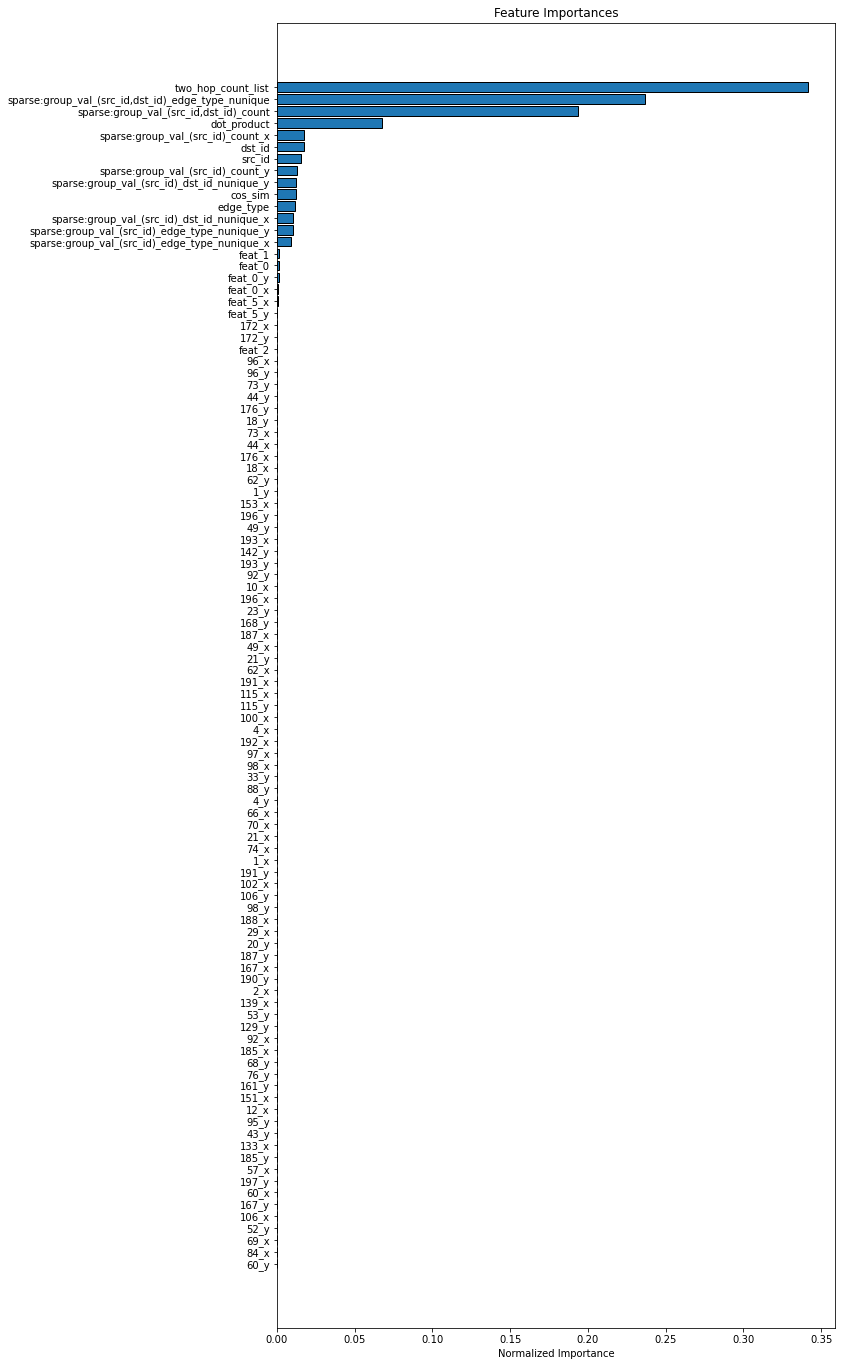

['two_hop_count_list', 'sparse:group_val_(src_id,dst_id)_edge_type_nunique', 'sparse:group_val_(src_id,dst_id)_count', 'dot_product', 'sparse:group_val_(src_id)_count_x', 'dst_id', 'src_id', 'sparse:group_val_(src_id)_count_y', 'sparse:group_val_(src_id)_dst_id_nunique_y', 'cos_sim', 'edge_type', 'sparse:group_val_(src_id)_dst_id_nunique_x', 'sparse:group_val_(src_id)_edge_type_nunique_y', 'sparse:group_val_(src_id)_edge_type_nunique_x', 'feat_1', 'feat_0', 'feat_0_y', 'feat_0_x', 'feat_5_x', 'feat_5_y', '172_x', '172_y', 'feat_2', '96_x', '96_y', '73_y', '44_y', '176_y', '18_y', '73_x', '44_x', '176_x', '18_x', '62_y', '1_y', '153_x', '196_y', '49_y', '193_x', '142_y', '193_y', '92_y', '10_x', '196_x', '23_y', '168_y', '187_x', '49_x', '21_y', '62_x', '191_x', '115_x', '115_y', '100_x', '4_x', '192_x', '97_x', '98_x', '33_y', '88_y', '4_y', '66_x', '70_x', '21_x', '74_x', '1_x', '191_y', '102_x', '106_y', '98_y', '188_x', '29_x', '20_y', '187_y', '167_x', '190_y', '2_x', '139_x', '53_

In [86]:
def plot_feature_importances(df, top_k=15):
    
    df = df.sort_values('importance', ascending = False).reset_index()

    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    plt.figure(figsize = (10, 24))
    ax = plt.subplot()

    ax.barh(list(reversed(list(df.index[:top_k]))), 
            df['importance_normalized'].head(top_k), 
            align = 'center', edgecolor = 'k')

    ax.set_yticks(list(reversed(list(df.index[:top_k]))))
    ax.set_yticklabels(df['feature'].head(top_k))

    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

top_k = 100
fi_sorted = plot_feature_importances(fi, top_k=top_k)
important_features = [x for x in fi_sorted['feature'].iloc[:top_k]]
print(important_features)